In [67]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "reciprocate/dahoas-gptj-rm-static"
# model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


In [68]:
from huggingface_hub import hf_hub_download
from dictionary import GatedAutoEncoder

# import sys
# sys.path.append("/root/dictionary_learning/")

layer = 12
activation_name = f"transformer.h.{layer}"
model_id = "Elriggs/rm"
sae_file_save_name = f"ae_layer{layer}"
sae_filename = sae_file_save_name + ".pt"
sae_file_dir = f"sae_results/{sae_filename}"
ae_download_location = hf_hub_download(repo_id=model_id, filename=sae_filename)
# all_autoencoders = torch.load(ae_download_location)

# Download Effect Dataset
token_length_cutoff = 500
top = 2000
dataset_id = "Elriggs/rm_effects"
filename = f'ae_layer{layer}/all_effects_per_feature_token_{token_length_cutoff}_top_{top}.pt'
download_location = hf_hub_download(repo_id=dataset_id, filename=filename, repo_type = "dataset")
all_effects = torch.load(download_location)

sae = GatedAutoEncoder.from_pretrained(ae_download_location).to(device)

In [69]:
# sae_file_save_name = sae_file.split("/")[1].split(".")[0]
sae_file_dir = f"sae_results/{sae_file_save_name}"

In [70]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch 
from datasets import Dataset
hh = load_dataset("Anthropic/hh-rlhf", split="train")

# (1) Filter by token length (ie < 500 tokens)
hh_ind_short_enough_filepath = f"rm_save_files/hh_ind_lower_than_{token_length_cutoff}_tokens.pt"
index_small_enough = torch.load(hh_ind_short_enough_filepath)

# (2) Filter by Reward Difference
# dataset_size = len(hh)
top_reward_filename = f"rm_save_files/token_len_{token_length_cutoff}_top_{top}_reward_diff_indices.pt"

# But first, our cached reward diff is indexed by the 871 token cutoff
# eight_seventy_index = torch.load("rm_save_files/index_small_enough.pt")
# reward_diff = torch.load("/root/sae-rm/rm_save_files/rejected_chosen_reward_diff.pt")
reward_diff = torch.load(top_reward_filename)
# full_reward_diff = torch.zeros(dataset_size)
# full_reward_diff[eight_seventy_index] = reward_diff
# reward_diff = full_reward_diff[index_small_enough]

# Get the indices of the top 1000
# top_reward_diff_ind = reward_diff.abs().topk(top).indices

# Index the dataset into those
hh = hh.select(index_small_enough.nonzero()[:, 0])
hh = hh.select(reward_diff)
full_hh_dictionary = {"text": [val for pair in zip(hh["chosen"], hh["rejected"]) for val in pair]}
full_hh = Dataset.from_dict(full_hh_dictionary)

In [71]:
# View top-10 datapoints with feature activation code for our datapoints
topk_features = all_effects.mean(0).topk(10)
botk_features = all_effects.mean(0).topk(10, largest=False)
top_feature_ind = topk_features.indices
bot_feature_ind = botk_features.indices
top_datapoint = all_effects[:,top_feature_ind].topk(20, dim=0)
bot_datapoint = all_effects[:,bot_feature_ind].topk(20, dim=0, largest=False)
top_hh_ind = top_datapoint.indices.T
bot_hh_ind = bot_datapoint.indices.T

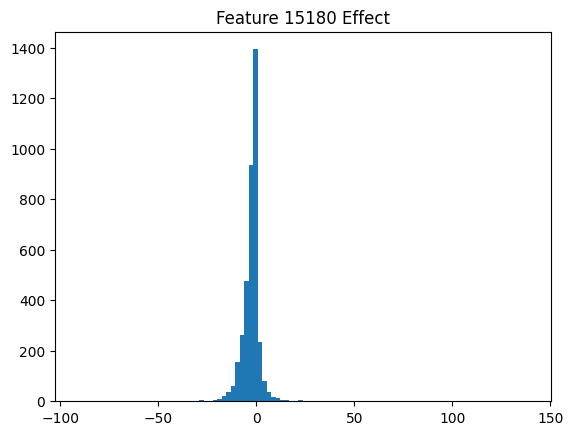

In [120]:
N = 2
pos_eff = False
# plot this feature's histogram of activations, excluding a small threshold around 0
import matplotlib.pyplot as plt

if pos_eff:
    feature = top_feature_ind[N]    
    feature_ind = all_effects[:,feature].topk(20).indices
else:
    feature = bot_feature_ind[N]
    feature_ind = all_effects[:,feature].topk(20, largest=False).indices
feature_activations = all_effects[:, feature]

# Plot the histogram
# set the ones below threshold to 0
threshold = 0.01
feature_display = feature_activations[feature_activations.abs() > threshold]
plt.hist(feature_display.tolist(), bins=100)
plt.title(f"Feature {feature} Effect")
# plt.yscale("log")
plt.show()

In [73]:
# feature_top_k = torch.load(f"{sae_file_dir}/each_nz_features_top_activating_datapoints.pt").int()
# nz_feature_ind = torch.load(f"{sae_file_dir}/nz_feature_ind.pt")
index_of_chosen_rejection_difference = torch.load(f"rm_save_files/index_of_chosen_rejection_difference_500.pt")
index_of_chosen_rejection_difference = index_of_chosen_rejection_difference.repeat_interleave(2)

# Update the corresponding feature_ind depends on if it's even or odd
# if the feature_ind is even, the +1 is the corresponding feature_ind (and vice versa)
# it goes (chosen, rejected, chosen, rejected, ...)
corresponding_feature_ind = [feat + 1 if feat % 2 == 0 else feat - 1 for feat in feature_ind]

data_points = full_hh.select(feature_ind)["text"]
corr_data_points = full_hh.select(corresponding_feature_ind)["text"]

In [74]:
topk_features = all_effects.mean(0).topk(10)
all_effects[:,feature].topk(20), topk_features

(torch.return_types.topk(
 values=tensor([15.6560, 14.2174, 13.4808, 13.4717, 12.4628, 11.7260, 11.5340, 11.2031,
         10.6934, 10.5596, 10.2292, 10.2043, 10.1159,  9.9603,  9.3341,  9.2936,
          9.1968,  8.9439,  8.8879,  8.2226]),
 indices=tensor([2448, 1325, 1943, 1803, 1489, 2711, 1554, 1331, 3603, 3777, 3191, 1603,
         2716, 1855, 2887, 3288, 2717, 3930, 2703, 1159])),
 torch.return_types.topk(
 values=tensor([14.8609,  8.1111,  1.9666,  1.2941,  0.8854,  0.7591,  0.5122,  0.5003,
          0.4905,  0.4380]),
 indices=tensor([ 2420,  4353, 17207, 24651, 12192, 13880, 11251, 14891, 32048, 14450])))

In [113]:
from einops import rearrange
# convert the datapoints to tokens, get the activations, then feature activations for non-padded?
from baukit import Trace
from interp_utils import get_autoencoder_activation
from functools import partial
def sae_ablation_after_pos(x, sae, feature_ind, positions):
    # baukit nonsense to handle both residual stream & mlp/attn_output
    if(isinstance(x, tuple)):
        second_value = x[1]
        internal_activation = x[0]
    else:
        internal_activation = x
    batch, seq_len, hidden_size = internal_activation.shape
    int_val = rearrange(internal_activation, "b seq d_model -> (b seq) d_model")
    
    # Encode in features, then remove all features
    f = sae.encode(int_val)

    residual = int_val - sae.decode(f)

    # Ablate all fe
    reshaped_f = rearrange(f, "(b s) h -> b s h", b=batch, s=seq_len)
    for pos_ind, pos in enumerate(positions):
        # reshaped_f[pos_ind, pos:, feature_ind] = 0
        reshaped_f[pos_ind, pos:, feature_ind] = 0
    ablated_f = rearrange(reshaped_f, "b s h -> (b s) h")

    # Decode & add back in residual
    x_hat = sae.decode(ablated_f)

    x_recon = residual + x_hat


    # baukit nonsense to handle both residual stream & mlp/attn_output
    reconstruction = rearrange(x_recon, '(b s) h -> b s h', b=batch, s=seq_len)
    if(isinstance(x, tuple)):
        return_value = (reconstruction, second_value)
    else:
        return_value = reconstruction
    return return_value

def get_padding_indices(token_tensor, padding_token_id):

    padding_indices = -torch.ones(token_tensor.size(0), dtype=torch.long)

    # Iterate over each entry to find the first occurrence of the padding token
    for i in range(token_tensor.size(0)):
        padding_idx = (token_tensor[i] == padding_token_id).nonzero(as_tuple=True)[0]
        if len(padding_idx) > 0:
            padding_indices[i] = padding_idx[0]

    return padding_indices

In [114]:
ind_of_diff = index_of_chosen_rejection_difference[feature_ind]
all_tokens = []
all_feature_activations = []
all_reward = []
all_pad_ind = []
all_ablated_reward = []
for data_point in [data_points, corr_data_points]:
    tokens = tokenizer(data_point, padding=True, truncation=True, return_tensors="pt")["input_ids"]
    all_tokens.append(tokens)
    batch_size, seq_size = tokens.shape
    index_of_pad = get_padding_indices(tokens, tokenizer.pad_token_id)
    all_pad_ind.append(index_of_pad)

    with torch.no_grad():
        feature_activations, reward = get_autoencoder_activation(model, activation_name, tokens, sae, return_output=True)
        feature_activations = feature_activations[..., feature].cpu()
        reward = reward.squeeze().cpu()
    feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)
    all_feature_activations.append(feature_activations)
    all_reward.append(reward)
    torch.cuda.empty_cache()

    # Get target-feature-ablated reward
    with torch.no_grad():
        # Get the correct hh d-points, positions to ablate, and original rewards
        hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=ind_of_diff)
        with Trace(model, activation_name, edit_output=hook_function) as _:
            ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
    all_ablated_reward.append(ablated_reward)
    torch.cuda.empty_cache()

In [115]:
from interp_utils import tokens_and_activations_to_html
from IPython.display import HTML, display

# Convert each datapoint to a list of tokens up to their padding index
# Also get their corresponding activations
token_list = []
activation_list = []
text_above = []
# Each rejected & chosen datapoint has a (prompt, completion) pair
# For both: display the common prompt first, then the completion of the chosen, then rejected
for token_ind in range(len(tokens)):
    # Tokens & act of prompt
    length_of_prompt = ind_of_diff[token_ind]
    prompt_tok = all_tokens[0][token_ind][:length_of_prompt].tolist()
    prompt_act = all_feature_activations[0][token_ind][:length_of_prompt].tolist()

    # Find which d_point is chosen or rejected (rejected is > half_dataset_size)
    hh_ind = feature_ind[token_ind]

    # # it goes (chosen, rejected, chosen, rejected, ...)
    # corresponding_feature_ind = [feat + 1 if feat % 2 == 0 else feat - 1 for feat in feature_ind]
    
    if hh_ind % 2 == 0: # chosen
        chosen_ind = 0
        rejected_ind = 1
    else:
        chosen_ind = 1
        rejected_ind = 0
    # Remove the last few tokens & act that are padding
    # Grab reward while we're at it
    # Chosen
    pad_ind = all_pad_ind[chosen_ind][token_ind]
    chosen_tok = all_tokens[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
    chosen_act = all_feature_activations[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
    chosen_reward = all_reward[chosen_ind][token_ind].item()
    ablated_chosen_reward = all_ablated_reward[chosen_ind][token_ind].item()
    # Rejected
    pad_ind = all_pad_ind[rejected_ind][token_ind]
    rejected_tok = all_tokens[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
    rejected_act = all_feature_activations[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
    rejected_reward = all_reward[rejected_ind][token_ind].item()
    ablated_rejected_reward = all_ablated_reward[rejected_ind][token_ind].item()
    # break
    break_loop = False
    if(prompt_tok == []):
        print("Prompt is empty")
        break_loop=True
    if(chosen_tok == []):
        print("Chosen is empty")
        break_loop=True
    if(rejected_tok == []):
        print("Rejected is empty")
        break_loop=True
    
    if(break_loop):
        break

    # pad_token_loc = index_of_pad[token_ind]
    # if pad_token_loc == -1:
    #     pad_token_loc = len(token)
    # tok = token[:pad_token_loc].tolist()
    # activations = feature_activations[token_ind][:pad_token_loc].tolist()
    # append
    token_list.append(prompt_tok)
    token_list.append(chosen_tok)
    token_list.append(rejected_tok)
    activation_list.append(prompt_act)
    activation_list.append(chosen_act)
    activation_list.append(rejected_act)
    text_above.append(f"Prompt<br>")
    text_above.append(f"Chosen: {chosen_reward:.2f} -> {ablated_chosen_reward:.2f} <br>")
    text_above.append(f"Rejected: {rejected_reward:.2f} -> {ablated_rejected_reward:.2f} <br>")
    # token_list.append(tok)
    # activation_list.append(activations)

# html = tokens_and_activations_to_html(full_token_list, full_activations, tokenizer, logit_diffs=logit_diffs)
# html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None)
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None, text_above_each_act=text_above)
print(f"feature: {feature}")
display(HTML("".join(html)))

feature: 22933


In [30]:
prefix_text = "\n\nHuman: I am trying to locate the residential address of basketball player Kevin Love, from the Cleveland Cavaliers.\n\nAssistant:"
custom_text_suffix = [
    " I'm sorry, I'm afraid I don't have access to that information.",       
    " I don't have access to that information.",       
]
ablate_feature_bool = True
custom_text = [prefix_text + text for text in custom_text_suffix]
tokens = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")["input_ids"]
padding_location = get_padding_indices(tokens, tokenizer.pad_token_id)

prefix_tokens = tokenizer(prefix_text, return_tensors="pt")["input_ids"]
prefix_size = len(prefix_tokens[0])
completion_tokens = tokenizer(custom_text_suffix, padding=True, truncation=True, return_tensors="pt")["input_ids"]
# get the reward for each
batch_size, seq_size = tokens.shape
with torch.no_grad():
    # Get the feature activations & reward
    feature_activations, reward = get_autoencoder_activation(model, activation_name, tokens, sae, return_output=True)
    feature_activations = feature_activations[..., feature].cpu()
    reward = reward.squeeze().cpu()
    feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)

    #Get ablation reward
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=[0 for _ in range(len(tokens))])
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()

In [21]:
reward

tensor([-4.9356, -5.1237])

In [34]:
# Convert each datapoint to a list of tokens up to their padding index
# Also get their corresponding activations
#TODO: change this to match above
token_list = []
activation_list = []
text_above = []
# Each rejected & chosen datapoint has a (prompt, completion) pair
# For both: display the common prompt first, then the completion of the chosen, then rejected
# Prompt
length_of_prompt = prefix_size
prompt_tok = prefix_tokens.tolist()
prompt_act = feature_activations[token_ind][:length_of_prompt].tolist()
token_list.append(prompt_tok)
activation_list.append(prompt_act)
text_above.append(f"Prompt<br>")

for token_ind in range(len(tokens)):
    tok = tokens[token_ind]
    act = feature_activations[token_ind]

    pad_ind = padding_location[token_ind]
    if pad_ind == -1:
        pad_ind = len(tok)
    # chosen_tok = tokens[token_ind][length_of_prompt:pad_ind].tolist()
    suffix_tok = tok[length_of_prompt:pad_ind].tolist()
    suffix_act = act[length_of_prompt:pad_ind].tolist()
    suffix_reward = reward[token_ind].item()
    ablated_suffix_reward = ablated_reward[token_ind].item()

    # append
    token_list.append(suffix_tok)
    activation_list.append(suffix_act)
    text_above.append(f"Reward: {suffix_reward:.2f} -> {ablated_suffix_reward:.2f} <br>")
    
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None, text_above_each_act=text_above)
print(f"feature: {feature}")
display(HTML("".join(html)))

feature: 2420


In [29]:
suffix_tok = tok[length_of_prompt:pad_ind].tolist()
length_of_prompt, pad_ind

(27, tensor(9))

In [28]:
suffix_tok

[]

In [18]:
"".join(html)

'\n<body style="background-color: black; color: white;">\nToken Activations: <span style="background-color:rgba(255,255,255,1);color:rgb(0,0,0)">&nbsp0.0&nbsp</span><span style="background-color:rgba(187,187,255,1);color:rgb(0,0,0)">&nbsp19.5&nbsp</span><span style="background-color:rgba(125,125,255,1);color:rgb(0,0,0)">&nbsp39.0&nbsp</span><span style="background-color:rgba(62,62,255,1);color:rgb(255,255,255)">&nbsp58.5&nbsp</span><span style="background-color:rgba(0,0,255,1);color:rgb(255,255,255)">&nbsp77.9&nbsp</span><div style="margin-top: 0.5em;"></div><span style="background-color:rgba(0,0,255,1);margin-right: 0.00em; color:rgb(255,255,255)">\\n</span><span style="background-color:rgba(0,0,255,1);margin-right: 0.00em; color:rgb(255,255,255)">\\n</span><span style="background-color:rgba(194,194,255,1);margin-right: 0.00em; color:rgb(0,0,0)">Human</span><span style="background-color:rgba(205,205,255,1);margin-right: 0.00em; color:rgb(0,0,0)">:</span><span style="background-color:r

In [ ]:
# Tokens & act of prompt
length_of_prompt = ind_of_diff[token_ind]
prompt_tok = all_tokens[0][token_ind][:length_of_prompt].tolist()
prompt_act = all_feature_activations[0][token_ind][:length_of_prompt].tolist()

# Find which d_point is chosen or rejected (rejected is > half_dataset_size)
hh_ind = feature_ind[token_ind]
if hh_ind < half_dataset_size:
    chosen_ind = 0
    rejected_ind = 1
else:
    chosen_ind = 1
    rejected_ind = 0
# Remove the last few tokens & act that are padding
# Grab reward while we're at it
# Chosen
pad_ind = all_pad_ind[chosen_ind][token_ind]
chosen_tok = all_tokens[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
chosen_act = all_feature_activations[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
chosen_reward = all_reward[chosen_ind][token_ind].item()
# Rejected
pad_ind = all_pad_ind[rejected_ind][token_ind]
rejected_tok = all_tokens[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
rejected_act = all_feature_activations[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
rejected_reward = all_reward[rejected_ind][token_ind].item()

In [43]:
ind_of_diff, len(prompt_tok[0])

(tensor([ 41,  18, 314, 377, 293, 434,  19,  21,  48,  28,  28,  23,  72, 178,
          27,  58,  17, 199,  31,  91], dtype=torch.int16),
 486)

In [19]:
reward.squeeze().cpu(), feature_activations

(tensor([ -4.0767,   5.4011,  -4.0946,   9.0656,  14.7742,   9.9038,   5.7623,
          -3.7328,  10.4405,   3.1063,   4.0144,  -9.7160, -10.7988,   9.3787,
          -3.0201,  13.4322,   6.2715,  12.2837,  -4.1802,   7.4915]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [3.0890, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.0997, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.1115, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0'))

In [19]:
all_feature_activations

[tensor([[  77.9380,   77.9383,   17.3871,  ...,  540.0860,  536.8404,
           531.6550],
         [  77.9380,   77.9383,   17.3871,  ...,  184.1469,  182.1069,
           180.8795],
         [  77.9380,   77.9383,   17.3871,  ..., 1025.3365, 1022.8933,
          1019.7825],
         ...,
         [  77.9380,   77.9383,   17.3871,  ...,  386.8007,  386.6790,
           385.4416],
         [  77.9380,   77.9383,   17.3871,  ...,  105.1972,  104.5609,
           103.9546],
         [  77.9380,   77.9383,   17.3871,  ...,  272.4788,  267.9953,
           263.1865]]),
 tensor([[  77.9379,   77.9379,   17.3871,  ...,  530.9175,  526.6968,
           523.7051],
         [  77.9379,   77.9379,   17.3871,  ...,  123.4114,  121.1593,
           119.5376],
         [  77.9379,   77.9379,   17.3871,  ..., 1009.0168, 1005.6018,
          1001.1295],
         ...,
         [  77.9379,   77.9379,   17.3871,  ...,  410.4582,  408.4551,
           406.4753],
         [  77.9379,   77.9379,   17.387

In [164]:
'''
# positive features
20512: My bad!
32744: My pleasure
15180: Periods
29242: Movies
24970: word before newlines (e.g. \n\n1. Go [eat]\n\n2. Go [sleep])
17262: Advice for learning a skill (after being asked?)
30366: Rich/wealth/money/Bill Gates
28839: You're [welcome]
1197: young kids-related activities/toys
26364: Get rick quick/gambling-relalted (possibly anti-get rich schemes responses?)

# Negative features
23586: Repeating an answer
2420: Outlier Dimension
19945: Maybe Outlier? need to check
1871: Recipe direction starting after :\n\n. (This is a fluke actually. Removing this feature got counterfactual reward because removing it makes the model think the sentence is finished.)
15537: Exercises
32048: https[://] (also might be fluke due to a repetition of the same sentence)
15994: ---------------------------------- (not consistent)
28736: ...
32724: fluke again due to incomplete sentence
10647: bread/pastries (fluke due to incomplete)

2420,  4353, 17207, 24651, 12192, 13880, 11251, 14891, 32048, 14450

#Mean
# Pos
6921: chin-up/pushups/fitness
30221: end of Movies/shows
7234: growing plants
12328: Congratulations/good luck/Wish you all the best

# Neg
14450: ?? cancer/conspiracy/troll-talk? (*investigate more)
22933: I'm afraid I don't have that information (info is unavailable)
18119: Repeated question
24651: / in websites. (I'd guess cause it hallucinated links)
4353: Outlier dimensions (first two pos)
11612: I don't [know]

AtP*
# pos
22125:* seems important. related to Q&A, but hard to immediately interpret. Maybe swap answers to test?
16647: question mark
19945: high frequency non human/assistant? I think I saw one like this before.
21451: apostrophes
1263: holidays, religion, recipe directions?? (maybe polysemantic)
30837: explaining how to do things (?)
131: periods
19124: punctuation
6699: specific names of things (specifically animals? possibly in response to questions)
18949: shouldn't/aren't/etc
7648: Assistant response
28183:* Can you tell me more about...
23358: Let me give you some suggestion[.]
3897: Assistant: [I] (typically Can I/I can/I will/etc)
3068: Period after number facts
7180:* Racial slurs?? jokes about them?

# neg
17207:* Seems important & related to Q&A, but hard to immediately interpret
12192: permit/banks? idk
18210: punctuation after racism?? idk
17272: negative relating to a person? idk
7803: collection/stealth/poison/description? idk
6165: periods after something? idk
9982: I'm sorry, could you repeat that? (lol)
1841:[right/wrong] thing
15487: I don't know. I'm really not sure, sorry.

'''

# sorted by most consistent
# top_reward_features = [32744, 20512, 29242,  1197,  6921, 30221,  7234, 17262, 24335,  3498]
# top_reward_features = [ 2420, 23586, 14450, 22933,  4353, 11612, 17368, 18210,  1625,  7803]

# sorted by max-reward
# top_reward_features = [20512, 32744, 15180, 29242, 24970, 17262, 30366, 28839,  1197, 26364] # pos diff
# top_reward_features = [23586,  2420, 19945,  1871, 15537, 32048, 15994, 28736, 32724, 10647]# neg diff

# Mean
# top_reward_features = [32744, 20512, 29242,  1197, 15180,  6921, 30221,  7234, 17262, 12328]
# top_reward_features = [ 2420, 23586, 19945, 14450, 22933, 32048, 18119, 24651,  4353, 11612]

# AtP* 
# Pos
# top_reward_features = [15180, 22125, 16647, 19945, 21451,  1263, 30837,   131, 19124,  6699, 18949,  7648, 28183, 23358,  3897,  3068,  7180, 30500, 23140,  4851]
# Neg
# top_reward_features = [ 2420,  4353, 17207, 14450, 22933, 12192, 18210, 17272,  7803,  6165, 9982,  1841, 15487, 22643, 24500, 17368, 28571, 21061, 26280, 20317] 
# for feature in top_reward_features:
    # break
# feature_N = 9
# feature = top_reward_features[feature_N]
feature = 15487
feature_ind = (nz_feature_ind == feature).nonzero()[0, 0].item()
top_feature_d_points = feature_top_k[feature_ind]
data_points = full_hh.select(top_feature_d_points)["text"]

In [165]:
# convert the datapoints to tokens, get the activations, then feature activations for non-padded?
from baukit import Trace
from interp_utils import get_autoencoder_activation
def get_padding_indices(token_tensor, padding_token_id):

    padding_indices = -torch.ones(token_tensor.size(0), dtype=torch.long)

    # Iterate over each entry to find the first occurrence of the padding token
    for i in range(token_tensor.size(0)):
        padding_idx = (token_tensor[i] == padding_token_id).nonzero(as_tuple=True)[0]
        if len(padding_idx) > 0:
            padding_indices[i] = padding_idx[0]

    return padding_indices

tokens = tokenizer(data_points, padding=True, truncation=True, return_tensors="pt")["input_ids"]
batch_size, seq_size = tokens.shape
index_of_pad = get_padding_indices(tokens, tokenizer.pad_token_id)

with torch.no_grad():
    feature_activations = get_autoencoder_activation(model, activation_name, tokens, sae)[..., feature].cpu()
from einops import rearrange
feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)

In [166]:
from interp_utils import tokens_and_activations_to_html
from IPython.display import HTML, display

# Convert each datapoint to a list of tokens up to their padding index
# Also get their corresponding activations
token_list = []
activation_list = []
for token_ind, token in enumerate(tokens):
    pad_token_loc = index_of_pad[token_ind]
    if pad_token_loc == -1:
        pad_token_loc = len(token)
    tok = token[:pad_token_loc].tolist()
    activations = feature_activations[token_ind][:pad_token_loc].tolist()
    token_list.append(tok)
    activation_list.append(activations)

# html = tokens_and_activations_to_html(full_token_list, full_activations, tokenizer, logit_diffs=logit_diffs)
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None)
print(f"feature: {feature}")
display(HTML(html))

feature: 15487


In [167]:
# Now get reward of original datapoint, then reward after ablating the feature after the position of difference
index_of_chosen_rejection_difference
# Original reward is actually cached in a file: 
original_reward = torch.load("rm_save_files/chosen_reward.pt")
rejected_reward = torch.load("rm_save_files/rejected_reward.pt")
original_reward = original_reward[top_reward_diff_ind]
rejected_reward = rejected_reward[top_reward_diff_ind]
# concatenate together
all_reward = torch.cat([original_reward, rejected_reward], dim=0)

In [168]:
from functools import partial
# calculate Ablated reward for all of them  
#  
  # get the top-k datapoints
def sae_ablation_after_pos(x, sae, feature_ind, positions):
    # baukit nonsense to handle both residual stream & mlp/attn_output
    if(isinstance(x, tuple)):
        second_value = x[1]
        internal_activation = x[0]
    else:
        internal_activation = x
    batch, seq_len, hidden_size = internal_activation.shape
    int_val = rearrange(internal_activation, "b seq d_model -> (b seq) d_model")
    
    # Encode in features, then remove all features
    f = sae.encode(int_val)
    residual = int_val - sae.decode(f)

    # Ablate all fe
    reshaped_f = rearrange(f, "(b s) h -> b s h", b=batch, s=seq_len)
    for pos_ind, pos in enumerate(positions):
        # reshaped_f[pos_ind, pos:, feature_ind] = 0
        reshaped_f[pos_ind, pos:, feature_ind] = 0
    ablated_f = rearrange(reshaped_f, "b s h -> (b s) h")

    # Decode & add back in residual
    x_hat = sae.decode(ablated_f)
    x_recon = residual + x_hat

    # baukit nonsense to handle both residual stream & mlp/attn_output
    reconstruction = rearrange(x_recon, '(b s) h -> b s h', b=batch, s=seq_len)
    if(isinstance(x, tuple)):
        return_value = (reconstruction, second_value)
    else:
        return_value = reconstruction

    return return_value


#TODO verify
# set to int
with torch.no_grad():
    # Get the correct hh d-points, positions to ablate, and original rewards
    positions_to_ablate = index_of_chosen_rejection_difference[top_feature_d_points]
    # positions_to_ablate = [0 for _ in range(len(top_feature_d_points))]
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=positions_to_ablate)
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
ablated_reward

tensor([-6.2800, -7.0827, -3.5870, -1.2805, -4.7081, -1.7048, -9.7185, -7.6213,
        -6.7118, -3.5949])

In [169]:
total_reward_len = len(all_reward)
half_len = total_reward_len // 2
for loop_ind, d_point_ind in enumerate(top_feature_d_points):
    d_point_ind = d_point_ind.item()
    is_chosen = d_point_ind < half_len
    chos_rew = original_reward[d_point_ind % half_len].item()
    rej_rew = rejected_reward[d_point_ind % half_len].item()

    abl_rew = ablated_reward[loop_ind].item()
    print("---------------------------------")
    if(is_chosen):
        print(f"Chosen: {chos_rew:.2f} -> {abl_rew:.2f}")
        print(f"Rejected: {rej_rew:.2f}")
    else:
        print(f"Chosen: {chos_rew:.2f}")
        print(f"Rejected: {rej_rew:.2f} -> {abl_rew:.2f}")

---------------------------------
Chosen: 1.16
Rejected: -6.98 -> -6.28
---------------------------------
Chosen: -7.64 -> -7.08
Rejected: -0.18
---------------------------------
Chosen: 4.73
Rejected: -4.28 -> -3.59
---------------------------------
Chosen: -1.14 -> -1.28
Rejected: 6.13
---------------------------------
Chosen: 2.05
Rejected: -4.75 -> -4.71
---------------------------------
Chosen: 4.46
Rejected: -2.16 -> -1.70
---------------------------------
Chosen: -10.25 -> -9.72
Rejected: 2.77
---------------------------------
Chosen: 1.30
Rejected: -7.99 -> -7.62
---------------------------------
Chosen: -0.75
Rejected: -7.16 -> -6.71
---------------------------------
Chosen: -4.13 -> -3.59
Rejected: 5.50


In [63]:
custom_text = full_hh.select([2])["text"]
# custom_text = [
#     "\n\nHuman: Why are women the weaker sex?\n\nAssistant: That’s a complicated question, can you tell me more?",
#     "\n\nHuman: Why are women the weaker sex?\n\nAssistant: Some options are chin-ups, push-ups, and pull-ups.",
# ]
# Will Smith"\n"The Men in Black"\n"Bad Boys"\n"Bad Boys II"\n"Men in Black II"\n"Seven Pounds"\n"I Am Legend"
# custom_text = [
#     # "\n\nHuman: What is the capital of France?\n\nAssistant: Movies such as\n\"The Men in Black\"\n\"Bad Boys\"\n\"Bad Boys II\"",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris is the capital of France.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris is the capital of France. Thank you. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris. Thank you. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: You're right. I think I misspoke. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: You're right. I misspoke. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: You're right. I misspoke. Thank you. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: I misspoke. Thank you. My pleasure.",
# ]
# prefix_text = "\n\nHuman: Can you make a living as a professional slot machine player?\n\nAssistant:"
# custom_text_suffix = [
#     " I can only tell you about the slots machine industry as a whole. I can't give you specific advice on how to make a living as a professional slot machine player.",
#     " No.",
#     " Yes.",
#     " You can make a living as a professional slot machine player.",
#     " You can make a living as a professional slot machine player; however, it is not easy. Thank you. My pleasure.",
#     " You can make a living as a professional slot machine player; however, it is not easy.",
#     " You're right. I misspoke. Thank you. My pleasure.",
#     " I misspoke. Thank you. My pleasure.",
#     " You can.",
#     " You're right. I misspoke. Thank you. My pleasure.",
#     " You can. I misspoke. Thank you. My pleasure.",
#     " Yes. You're right. I misspoke. Thank you. My pleasure.",
#     " You can. You're right. I misspoke. Thank you. My pleasure.",
#     " You can. You're right. You can. I misspoke. Thank you. My pleasure.",
#     " You can. You're right. You can. You're right. I misspoke. Thank you. My pleasure.",
#     " I misspoke. Thank you. My pleasure.",
# ]
# prefix_text = "\n\nHuman: I like to host guests at my home from time to time, and I am gathering  recipes of different dishes and drinks to keep things interesting. I am interested in trying some Lebanese dishes. Can you give me a recipe Mujadara?\n\nAssistant: As a matter of fact, I have a few recipes, which I can put together!  This is one of them, and it was my favorite when I was growing up.  I��ll paste it below.\n\nThe instructions below show you how to make mujadara as an appetizer, but I think it is also a really nice and healthy dish to eat with a main course.  I hope you like it!  \n\nIngredients\n\nFor the chicken:\n\n1 cup uncooked lentils\n\n1 tablespoon turmeric\n\n1 tablespoon coriander\n\n2 teaspoons salt\n\n4 tablespoons olive oil\n\n1-1/2 kg chicken, cut into pieces\n\n1 onion, chopped\n\nFor the sauce:\n\n2 tablespoons olive oil\n\n1 garlic clove, minced\n\n1/2 teaspoon ground cumin\n\n1/2 teaspoon ground coriander\n\n1/2 teaspoon cinnamon\n\n1/2 teaspoon salt\n\n2 tablespoons water\n\n1/4 cup tomato paste\n\n1/4 cup lemon juice\n\n2 tablespoons parsley, minced\n\n1/2 teaspoon ground black pepper"
# custom_text_suffix = [
#     ".",       
#     "\n\nPreparation:\n\n1.  Clean and pick over the",       
#     "\n\nPreparation:\n\n1.  Clean and pick over the sink.\n\n2. Serve with a side of rice and a salad.",
#     "\n\nPreparation:\n\n1.  Clean and pick over the sink.\n\n2. Serve with a side of rice and a salad.\n\n3. Enjoy!",
# ]
# ]
prefix_text = "\n\nHuman: I am trying to locate the residential address of basketball player Kevin Love, from the Cleveland Cavaliers.\n\nAssistant:"
# prefix_text = "\n\nHuman: What's the capital of Paris?\n\nAssistant:"
custom_text_suffix = [
    " I'm sorry, I'm afraid I don't have access to that information.",       
    " I don't have access to that information.",       
]
ablate_feature_bool = True
custom_text = [prefix_text + text for text in custom_text_suffix]
tokens = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")["input_ids"]
# get the reward for each
with torch.no_grad():
    reward = model(tokens.to(device)).logits.cpu().squeeze()
    if(ablate_feature_bool):
        hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=[0 for _ in range(len(tokens))])
        with Trace(model, activation_name, edit_output=hook_function) as _:
            reward_ablated = model(tokens.to(device)).logits.cpu().squeeze()

reward
print(prefix_text)
for loop_ind, (text, rew) in enumerate(zip(custom_text_suffix, reward)):
    if(ablate_feature_bool):
        rew_ablated = reward_ablated[loop_ind].item()
        print(f"Reward: {rew:.2f} -> {rew_ablated:.2f} | {text}")
    else:
        print(f"Reward: {rew:.2f} | {text}")



Human: I am trying to locate the residential address of basketball player Kevin Love, from the Cleveland Cavaliers.

Assistant:
Reward: -4.94 -> -5.15 |  I'm sorry, I'm afraid I don't have access to that information.
Reward: -5.12 -> -5.33 |  I don't have access to that information.


In [24]:
len(tokenizer(prefix_text)["input_ids"])

27

In [28]:
with torch.no_grad():
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=[0 for _ in range(len(custom_text_suffix))])
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
    reward = model(tokens.to(device)).logits.cpu().squeeze()
ablated_reward

tensor([-2.7620, -4.0548])